# This notebook evaluates the predictions of the TinyBert Baseline output

In [1]:
import pandas as pd
from sklearn.metrics import f1_score
import os
import numpy as np
import matplotlib.pyplot as plt
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

In [2]:
#get path information
product_path = '../../../../src/data/product'
train_test_all_filtered_path_2 = os.path.join(product_path, 'train_test_split/output_unfiltered_tables/large/after_manual_checking/baselines')
data_path = '../../../../src/data'
mapping_corpus_path_2 = data_path + r'/product/lspc2020_to_tablecorpus/Cleaned'
train_test_all_filtered_path = os.path.join(product_path, 'train_test_split/output_unfiltered_tables/large/after_manual_checking')
error_analysis_path = os.path.join(product_path, 'error_analysis')
visualization_path = '../../../../visualizations'

In [3]:
#load the TinyBert results
res = pd.read_csv('../Baseline/TinyBert_Results/predict_results_None.txt', sep='\t')
res.drop('index', axis=1, inplace=True)
res

,prediction
0,442
1,591
2,245
3,570
4,569
...,...
10650,70
10651,184
10652,648
10653,565


In [4]:
#load the test set
real = pd.read_csv(os.path.join(train_test_all_filtered_path_2,'df_test.csv'))

In [5]:
real

,sentence1,label
0,WD 2TB Elements Portable External Hard Drive -...,442
1,GoPro Head Strap + Quick Clip nan,591
2,GoPro 3 way grip Arm GoPro nan,245
3,Akérat Smoothing Exfoliating Cream <p>Targeted...,692
4,Moisturizing Self-Tanning Silky Gel <p>Non-gre...,223
...,...,...
10650,Apple Lightning to USB-C Cable (2m) Apple Ligh...,70
10651,Apple Lightning to VGA adapter Apple Lightning...,184
10652,Apple Lightning to Digital AV adapter Apple Li...,45
10653,Rolex Watches Oyster Perpetual GMT-Master II 1...,565


In [6]:
final = pd.concat([real,res], axis=1)

In [7]:
f1_score(real.label, res.prediction, average='micro')

0.8329422806194275

In [8]:
f1_scores = f1_score(real.label, res.prediction, average=None, labels=real.label)
f1_scores_with_labels = {label:score for label,score in zip(real.label, f1_scores)}

In [9]:
df_f1 = pd.DataFrame.from_dict(f1_scores_with_labels, orient="index").reset_index().rename(columns={'index':'label',0:'f1'}).sort_values(by=['label'])
df_f1

,label,f1
334,0,1.000000
937,1,0.500000
960,2,1.000000
469,3,0.400000
581,4,0.250000
...,...,...
111,1405,1.000000
1000,1406,1.000000
863,1407,1.000000
115,1408,0.977778


In [10]:
# get information on label, prediction, and cluster itself in one table
#df_join_sentence = pd.merge(df_f1, real.drop_duplicates(subset=['label']), how="left", on=["label", "label"])

In [11]:
# get information on label, prediction, and cluster itself in one table
#pd.merge(final, df_f1, how="left", on=["label", "label"]).sort_values(by=['label']).to_excel('f1_per_cluster_baseline.xlsx')

# F1 Scores for different domains

In [12]:
domains=['Bikes','Cars','Technology','Electronics','Random','Drugstore','Clothes']

In [13]:
#get all clusters with information
combined_csv_data = pd.concat([pd.read_csv(os.path.join(mapping_corpus_path_2, f"{file}_cluster_8_tables.csv")) for file in domains]).drop(columns=['Unnamed: 0'])

In [14]:
#get cluster_ids
cluster_list=[]
files_representation_train = [file for file in os.listdir(os.path.join(train_test_all_filtered_path,'train_cleaned')) if file.endswith('.json.gz')]
for zip_file in files_representation_train:
    df = pd.read_json(os.path.join(train_test_all_filtered_path,'train_cleaned') + '/{}'.format(zip_file), compression='gzip', lines=True)
    cluster_list.extend(df['cluster_id'].tolist())
    # get only clusters that are unique
unique_clusters = np.unique(cluster_list)
unique_clusters = np.delete(unique_clusters, 0)

In [15]:
combined_csv_data_filter = combined_csv_data[combined_csv_data['cluster_id'].isin(unique_clusters)].drop_duplicates(subset=['cluster_id'])

In [16]:
#scale cluster_ids
combined_csv_data_filter['label'] = combined_csv_data_filter.groupby('cluster_id').ngroup()
#combine information with predictions and labels
df_domain_f1 = pd.merge(final.drop(columns='sentence1'), combined_csv_data_filter.drop(columns=['cluster_id']), how="left", on=["label", "label"])

In [17]:
f1_domain_f1_overview = []
for domain in domains:
    f1_domain = f1_score(df_domain_f1[df_domain_f1['domain']==domain].label, df_domain_f1[df_domain_f1['domain']==domain].prediction, average='micro')
    print(f"F1 Score for {domain}: {f1_domain}")
    f1_domain_f1_overview.append(f1_domain)

F1 Score for Bikes: 1.0
F1 Score for Cars: 0.8701298701298701
F1 Score for Technology: 0.9510869565217391
F1 Score for Electronics: 0.7592715231788081
F1 Score for Random: 0.8593436034829202
F1 Score for Drugstore: 0.5994897959183674
F1 Score for Clothes: 0.7196428571428571


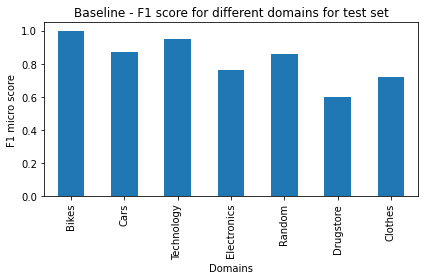

In [18]:
pd.DataFrame(pd.DataFrame(list(zip(domains,f1_domain_f1_overview))).rename(columns={0:'bin',1:'f1'})).plot(x='bin', y='f1', kind="bar", legend=None)
    
plt.ylabel('F1 micro score')
plt.xlabel('Domains')
plt.title('Baseline - F1 score for different domains for test set')
plt.tight_layout()
plt.savefig(os.path.join(visualization_path, 'Baseline_F1_domains_test.png'))
plt.show()

# F1 scores for size of train data

In [19]:
#load the train set
df_train = pd.read_csv(os.path.join(train_test_all_filtered_path_2,'df_train.csv'))
#join label, predictions and amount test set
df_amount_train_f1 = pd.merge(final.drop(columns='sentence1'), df_train.groupby('label').count(), how="left", on=["label", "label"])

In [20]:
df_amount_train_f1

,label,prediction,sentence1
0,442,442,11
1,591,591,9
2,245,245,12
3,692,570,6
4,223,569,3
...,...,...,...
10650,70,70,6
10651,184,184,2
10652,45,648,4
10653,565,565,4


In [21]:
bins = [0, 5, 10, 15, 25, 50, 100, 150]
#create bins for categorization
df_amount_train_f1['binned'] = pd.cut(df_amount_train_f1['sentence1'], bins)

In [22]:
f1_bin_f1_overview = []
for interval in sorted(df_amount_train_f1['binned'].unique().to_list()):
    f1_train_size = f1_score(df_amount_train_f1[df_amount_train_f1['binned']==interval].label, df_amount_train_f1[df_amount_train_f1['binned']==interval].prediction, average='micro')
    print(f"F1 Score for size of train set per cluster in {interval}: {f1_train_size}")
    f1_bin_f1_overview.append(f1_train_size)

F1 Score for size of train set per cluster in (0, 5]: 0.6513605442176871
F1 Score for size of train set per cluster in (5, 10]: 0.8269733403031886
F1 Score for size of train set per cluster in (10, 15]: 0.9178981937602627
F1 Score for size of train set per cluster in (15, 25]: 0.9407294832826748
F1 Score for size of train set per cluster in (25, 50]: 0.9682352941176471
F1 Score for size of train set per cluster in (50, 100]: 0.9788106630211895
F1 Score for size of train set per cluster in (100, 150]: 0.9523809523809523


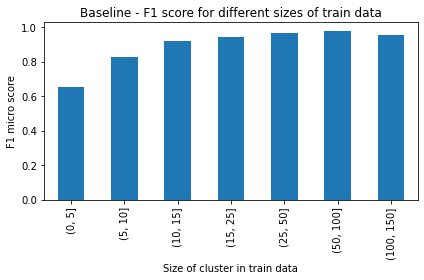

In [23]:
pd.DataFrame(pd.DataFrame(list(zip(sorted(df_amount_train_f1['binned'].unique().to_list()),f1_bin_f1_overview))).rename(columns={0:'bin',1:'f1'})).plot(x='bin', y='f1', kind="bar", legend=None)

plt.ylabel('F1 micro score')
plt.xlabel('Size of cluster in train data')
plt.title('Baseline - F1 score for different sizes of train data')
plt.tight_layout()
plt.savefig(os.path.join(visualization_path, 'Baseline_F1_train_size.png'))
plt.show()

# F1 scores for description column 

### We only look at the description, as the name is only once not given with the description column empty as well. So, it is irrelevant. Around 2800 entities do not have a description.

In [24]:
#load test data
df_test= pd.read_json(os.path.join(train_test_all_filtered_path,'test/concatenated_data/test_all_filtered_tables.json.gz'), compression='gzip', lines=True)
df_test = df_test[['name','description','cluster_id']]
#scale cluster_ids
df_test['label'] = df_test.groupby('cluster_id').ngroup()

In [25]:
df_test

,name,description,cluster_id,label
0,WD 2TB Elements Portable External Hard Drive -...,Brand: Western Digital Color: black Features: ...,541658,442
1,GoPro Head Strap + Quick Clip,nan,863679,591
2,GoPro 3 way grip Arm GoPro,nan,251884,245
3,Akérat Smoothing Exfoliating Cream,<p>Targeted body cream smoothes and retexturiz...,1107309,692
4,Moisturizing Self-Tanning Silky Gel,"<p>Non-greasy, hydrating self-tanner gives the...",230191,223
...,...,...,...,...
10650,Apple Lightning to USB-C Cable (2m),Apple Lightning to USB-C Cable (2m),51314,70
10651,Apple Lightning to VGA adapter,Apple Lightning to VGA adapter,185147,184
10652,Apple Lightning to Digital AV adapter,Apple Lightning to Digital AV adapter,32374,45
10653,Rolex Watches Oyster Perpetual GMT-Master II 1...,Brand : Replica Rolex Collection : Oyster Perp...,800686,565


In [26]:
#replace missing values
df_test = df_test.replace(r'^\s*$', np.NaN, regex=True).replace("nan", 0)
df_test['name'] = df_test['name'].fillna(0)
df_test['description'] = df_test['description'].fillna(0)

In [27]:
df_empty_desc_f1 = pd.merge(final.drop(columns='sentence1'), df_test.drop(columns=['cluster_id','label']), how="left",left_index=True, right_index=True)
#f1 with description
f1_domain_with = f1_score(df_empty_desc_f1[df_empty_desc_f1['description']!=0].label, df_empty_desc_f1[df_empty_desc_f1['description']!=0].prediction, average='micro')
print(f"F1 Score for entities with description: {f1_domain_with}")
#f1 without description
f1_domain_without = f1_score(df_empty_desc_f1[df_empty_desc_f1['description']==0].label, df_empty_desc_f1[df_empty_desc_f1['description']==0].prediction, average='micro')
print(f"F1 Score for without description: {f1_domain_without}")

F1 Score for entities with description: 0.8053708439897698
F1 Score for without description: 0.908994708994709


# F1 scores for lentgh of tokens without description column 

In [28]:
#examples without description
df_without = df_empty_desc_f1[df_empty_desc_f1['description']==0]
df_without['amount_tokens'] = df_empty_desc_f1['name'].str.len()
df_without['amount_tokens'] = df_without['amount_tokens'].fillna(0).apply(int)
df_without

/tmp/ipykernel_2221555/2903924671.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_without['amount_tokens'] = df_empty_desc_f1['name'].str.len()
/tmp/ipykernel_2221555/2903924671.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_without['amount_tokens'] = df_without['amount_tokens'].fillna(0).apply(int)


,label,prediction,name,description,amount_tokens
1,591,591,GoPro Head Strap + Quick Clip,0,29
2,245,245,GoPro 3 way grip Arm GoPro,0,26
6,1286,1286,"Ascenta Recessed Hndl, 6/2 Cycles, 50 dBA, Adj...",0,56
7,1243,1243,5.2 cu. ft. Mega Capacity TurboWash&reg; Washe...,0,69
8,1234,1234,36&quot; Wall Mount Hood in Black Stainless Steel,0,49
...,...,...,...,...,...
10593,801,801,85&quot; Class Q90T QLED 4K UHD HDR Smart TV (...,0,51
10594,593,593,75&quot; Class Q60T QLED 4K UHD HDR Smart TV (...,0,51
10595,1152,1152,65&quot; Class Q60T QLED 4K UHD HDR Smart TV (...,0,51
10596,1121,1121,49&quot; Class Q80T QLED 4K UHD HDR Smart TV (...,0,51


In [29]:
bins2 = [0, 5, 10, 15, 25, 50, 100, 500, 2500]
#create bins for categorization
df_without['binned'] = pd.cut(df_without['amount_tokens'], bins2)
df_without

/tmp/ipykernel_2221555/94680625.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_without['binned'] = pd.cut(df_without['amount_tokens'], bins2)


,label,prediction,name,description,amount_tokens,binned
1,591,591,GoPro Head Strap + Quick Clip,0,29,"(25, 50]"
2,245,245,GoPro 3 way grip Arm GoPro,0,26,"(25, 50]"
6,1286,1286,"Ascenta Recessed Hndl, 6/2 Cycles, 50 dBA, Adj...",0,56,"(50, 100]"
7,1243,1243,5.2 cu. ft. Mega Capacity TurboWash&reg; Washe...,0,69,"(50, 100]"
8,1234,1234,36&quot; Wall Mount Hood in Black Stainless Steel,0,49,"(25, 50]"
...,...,...,...,...,...,...
10593,801,801,85&quot; Class Q90T QLED 4K UHD HDR Smart TV (...,0,51,"(50, 100]"
10594,593,593,75&quot; Class Q60T QLED 4K UHD HDR Smart TV (...,0,51,"(50, 100]"
10595,1152,1152,65&quot; Class Q60T QLED 4K UHD HDR Smart TV (...,0,51,"(50, 100]"
10596,1121,1121,49&quot; Class Q80T QLED 4K UHD HDR Smart TV (...,0,51,"(50, 100]"


In [30]:
df_without.describe()

,label,prediction,amount_tokens
count,2835.000000,2835.000000,2835.000000
mean,1077.926984,1060.082187,70.231746
std,332.432048,346.470996,44.029513
min,5.000000,5.000000,0.000000
25%,1055.000000,973.500000,53.000000
50%,1194.000000,1185.000000,68.000000
75%,1293.000000,1291.000000,85.000000
max,1408.000000,1408.000000,2047.000000


In [31]:
for interval in df_without['binned'].unique().to_list():
    f1_train_size = f1_score(df_without[df_without['binned']==interval].label, df_without[df_without['binned']==interval].prediction, average='micro')
    print(f"F1 Score for size of train set per cluster in {interval}: {f1_train_size}")
    f1_bin_f1_overview.append(f1_train_size)

F1 Score for size of train set per cluster in (25.0, 50.0]: 0.7755555555555554
F1 Score for size of train set per cluster in (50.0, 100.0]: 0.9470499243570348
F1 Score for size of train set per cluster in (100.0, 500.0]: 0.906060606060606
F1 Score for size of train set per cluster in (15.0, 25.0]: 0.7254901960784313
F1 Score for size of train set per cluster in (10.0, 15.0]: 0.8181818181818182
F1 Score for size of train set per cluster in (0.0, 5.0]: 0.5
F1 Score for size of train set per cluster in (500.0, 2500.0]: 0.0
F1 Score for size of train set per cluster in (5.0, 10.0]: 0.6666666666666666
F1 Score for size of train set per cluster in nan: 0.0


/home/bizer-tp2021/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


# Compare different settings to description

In [32]:
df_domain_description = pd.merge(df_domain_f1, df_empty_desc_f1.drop(columns=['label','prediction']), how="left", left_index=True, right_index=True)

In [33]:
df_domain_description

,label,prediction,domain,name,description
0,442,442,Electronics,WD 2TB Elements Portable External Hard Drive -...,Brand: Western Digital Color: black Features: ...
1,591,591,Electronics,GoPro Head Strap + Quick Clip,0
2,245,245,Electronics,GoPro 3 way grip Arm GoPro,0
3,692,570,Drugstore,Akérat Smoothing Exfoliating Cream,<p>Targeted body cream smoothes and retexturiz...
4,223,569,Drugstore,Moisturizing Self-Tanning Silky Gel,"<p>Non-greasy, hydrating self-tanner gives the..."
...,...,...,...,...,...
10650,70,70,Electronics,Apple Lightning to USB-C Cable (2m),Apple Lightning to USB-C Cable (2m)
10651,184,184,Electronics,Apple Lightning to VGA adapter,Apple Lightning to VGA adapter
10652,45,648,Electronics,Apple Lightning to Digital AV adapter,Apple Lightning to Digital AV adapter
10653,565,565,Clothes,Rolex Watches Oyster Perpetual GMT-Master II 1...,Brand : Replica Rolex Collection : Oyster Perp...


In [34]:
df_domain_description_count = pd.merge(df_domain_description, df_amount_train_f1.drop(columns=['label','prediction','sentence1']), how="left", left_index=True, right_index=True)

In [35]:
df_domain_description_count

,label,prediction,domain,name,description,binned
0,442,442,Electronics,WD 2TB Elements Portable External Hard Drive -...,Brand: Western Digital Color: black Features: ...,"(10, 15]"
1,591,591,Electronics,GoPro Head Strap + Quick Clip,0,"(5, 10]"
2,245,245,Electronics,GoPro 3 way grip Arm GoPro,0,"(10, 15]"
3,692,570,Drugstore,Akérat Smoothing Exfoliating Cream,<p>Targeted body cream smoothes and retexturiz...,"(5, 10]"
4,223,569,Drugstore,Moisturizing Self-Tanning Silky Gel,"<p>Non-greasy, hydrating self-tanner gives the...","(0, 5]"
...,...,...,...,...,...,...
10650,70,70,Electronics,Apple Lightning to USB-C Cable (2m),Apple Lightning to USB-C Cable (2m),"(5, 10]"
10651,184,184,Electronics,Apple Lightning to VGA adapter,Apple Lightning to VGA adapter,"(0, 5]"
10652,45,648,Electronics,Apple Lightning to Digital AV adapter,Apple Lightning to Digital AV adapter,"(0, 5]"
10653,565,565,Clothes,Rolex Watches Oyster Perpetual GMT-Master II 1...,Brand : Replica Rolex Collection : Oyster Perp...,"(0, 5]"


In [36]:
df_domain_description_count_without = df_domain_description_count[df_domain_description_count['description']==0]
df_domain_description_count_with = df_domain_description_count[df_domain_description_count['description']!=0]

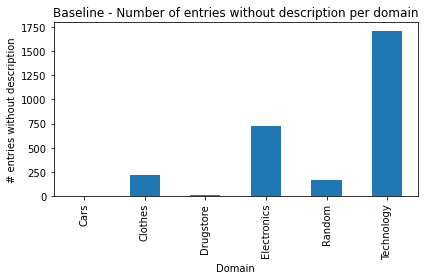

In [37]:
#df_domain_description_count_without['domain'].hist()
df_domain_description_count_without2 = df_domain_description_count_without.groupby('domain').count().reset_index().drop(columns=['label', 'prediction', 'description', 'binned'])
df_domain_description_count_without2.plot(x="domain", y="name", kind="bar", legend=None)

plt.ylabel('# entries without description')
plt.xlabel('Domain')
plt.title('Baseline - Number of entries without description per domain')
plt.tight_layout()
plt.savefig(os.path.join(visualization_path, 'Baseline_amt_without_desc_domain.png'))
plt.show()

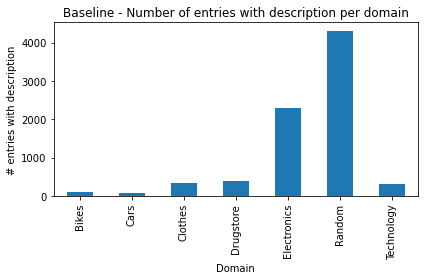

In [38]:
df_domain_description_count_with2 = df_domain_description_count_with.groupby('domain').count().reset_index().drop(columns=['label', 'prediction', 'description', 'binned'])
df_domain_description_count_with2.plot(x="domain", y="name", kind="bar", legend=None)

plt.ylabel('# entries with description')
plt.xlabel('Domain')
plt.title('Baseline - Number of entries with description per domain')
plt.tight_layout()
plt.savefig(os.path.join(visualization_path, 'Baseline_amt_with_desc_domain.png'))
plt.show()

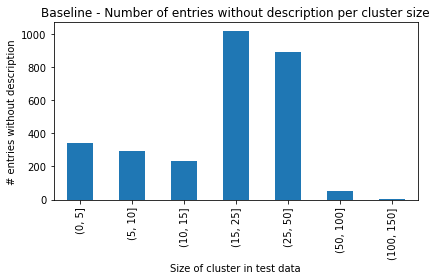

In [39]:
df_domain_description_count_without3 = df_domain_description_count_without.groupby('binned').count().reset_index().drop(columns=['label', 'prediction', 'description', 'domain'])
df_domain_description_count_without3.plot(x="binned", y="name", kind="bar", legend=None)

plt.ylabel('# entries without description')
plt.xlabel('Size of cluster in test data')
plt.title('Baseline - Number of entries without description per cluster size')
plt.tight_layout()
plt.savefig(os.path.join(visualization_path, 'Baseline_amt_without_desc_set_size.png'))
plt.show()

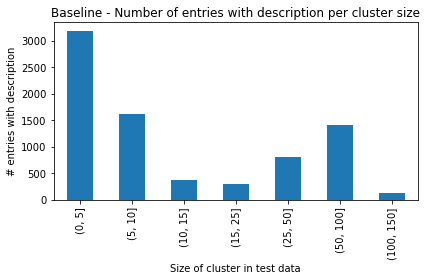

In [40]:
df_domain_description_count_with3 = df_domain_description_count_with.groupby('binned').count().reset_index().drop(columns=['label', 'prediction', 'description', 'domain'])
df_domain_description_count_with3.plot(x="binned", y="name", kind="bar", legend=None)

plt.ylabel('# entries with description')
plt.xlabel('Size of cluster in test data')
plt.title('Baseline - Number of entries with description per cluster size')
plt.tight_layout()
plt.savefig(os.path.join(visualization_path, 'Baseline_amt_with_desc_set_size.png'))
plt.show()

# Compare attribute mistakes

In [41]:
#function to remove words from an input list in a token_vector
def remove_stopwords(token_vector, stopwords_list):
    return token_vector.apply(lambda token_list: [word for word in token_list if word not in stopwords_list])

In [42]:
#function to remove punctuation in a token_vector
def remove_punctuation(token_vector):
    return token_vector.apply(lambda token_list: [word for word in token_list if word not in string.punctuation])

In [43]:
#function to compute jaccard similarity
def jaccard_similarity_score(original, translation):
    intersect = set(original).intersection(set(translation))
    union = set(original).union(set(translation))
    try:
        return len(intersect) / len(union)
    except ZeroDivisionError:
        return 0

In [44]:
#load test data
df_test= pd.read_json(os.path.join(train_test_all_filtered_path,'test/concatenated_data/test_all_filtered_tables.json.gz'), compression='gzip', lines=True)
df_test = df_test[['name','description','cluster_id']]
#scale cluster_ids
df_test['label'] = df_test.groupby('cluster_id').ngroup()

In [45]:
df_test

,name,description,cluster_id,label
0,WD 2TB Elements Portable External Hard Drive -...,Brand: Western Digital Color: black Features: ...,541658,442
1,GoPro Head Strap + Quick Clip,nan,863679,591
2,GoPro 3 way grip Arm GoPro,nan,251884,245
3,Akérat Smoothing Exfoliating Cream,<p>Targeted body cream smoothes and retexturiz...,1107309,692
4,Moisturizing Self-Tanning Silky Gel,"<p>Non-greasy, hydrating self-tanner gives the...",230191,223
...,...,...,...,...
10650,Apple Lightning to USB-C Cable (2m),Apple Lightning to USB-C Cable (2m),51314,70
10651,Apple Lightning to VGA adapter,Apple Lightning to VGA adapter,185147,184
10652,Apple Lightning to Digital AV adapter,Apple Lightning to Digital AV adapter,32374,45
10653,Rolex Watches Oyster Perpetual GMT-Master II 1...,Brand : Replica Rolex Collection : Oyster Perp...,800686,565


In [46]:
#use tokenizer for product names to get tokes for training the model
df_test['product_tokens'] = df_test['name'].apply(lambda row: word_tokenize(row))
df_test['product_tokens'] = remove_stopwords(df_test['product_tokens'],stopwords.words())
df_test['product_tokens'] = remove_punctuation (df_test['product_tokens'])
#get tagged words
tagged_data = [TaggedDocument(words=_d, tags=[str(i)]) for i, _d in enumerate(df_test['product_tokens'])]
# build model and vocabulary
model = Doc2Vec(vector_size=50, min_count = 5, epochs = 25, dm = 0)
model.build_vocab(tagged_data)
# Train model
model.train(tagged_data, total_examples=model.corpus_count, epochs=25)

In [47]:
#get data from prefiltered excel file -> had a look into mistakes by hand and collected some
df_attribute = pd.read_excel(os.path.join(error_analysis_path,'f1_per_cluster_baseline.xlsx'))

In [48]:
df_attribute

,sentence1,label,prediction,f1,Unterschiedliche Attribute
0,Intel Core i9-9900X 3.5 GHz Ten-Core LGA 2066 ...,3,242,0.4,"Unterschied in einem Attribut: 3,5 zu 5 GHz"
1,Intel Skylake Core i9-9900X 3.5G 2066 19.25M F...,3,3,0.4,NaN
2,Intel Core i9-9900X X-Series Processor 10 Core...,3,242,0.4,"Unterschied in einem Attribut: 3,5 zu 5 GHz"
3,LOGITECH G300s GAMING MOUSE Logıtech G300s Gam...,11,386,0.0,Logitech Bluetooth Adapter
4,Logitech G300s Refresh Souris Gamer optique - ...,11,166,0.0,Logitech Stereo Headset
...,...,...,...,...,...
295,Sandisk Ultra 128gb Micro Sd 100mb/S Memory Ca...,253,493,0.0,GNCZN
296,SANDISK SDSQUAR-128G-GN6MA 128 GB Ultra 100 MB...,253,493,0.0,GNCZN
297,Micro SD 128GB SanDisk SanDisk Micro SDXC UHS-...,253,493,0.0,GNCZN
298,SanDisk Ultra microSDXC 128GB UHS-I Class 10 M...,253,493,0.0,GNCZN


In [49]:
#get cluster ids from excel file to be able to retrieve hard cases
top_clusters_list = df_attribute.label.unique().tolist()
index_top_clusters_list=[]
for id in top_clusters_list:
    index_top_clusters_list.append(df_test[df_test['label']==id].index[0])

In [50]:
# get most similar cases for each of the prefiltered cases
most_similar_clusters=[]
for i in index_top_clusters_list:
    similar_doc = model.docvecs.most_similar(f'{i}', topn = 5)
    most_similar_clusters.append(int(i))
    for index, similarity in similar_doc:
        most_similar_clusters.append(int(index))
    jaccard_score = df_test['product_tokens'].apply(lambda row: jaccard_similarity_score(row,df_test.iloc[int(i)]['product_tokens']) )
    indizes=sorted(range(len(jaccard_score)), key=lambda i: jaccard_score[i])[-5:]
    for index in indizes:
        most_similar_clusters.append(int(index))    
df_final_attribute_test = df_test.iloc[most_similar_clusters]
#drop duplicates in  final test set
df_final_attribute_test = df_final_attribute_test.drop_duplicates(subset=['name','description','cluster_id','label'])

In [51]:
df_final_attribute_test

,name,description,cluster_id,label,product_tokens
800,Intel Core i9-9900X 3.5 GHz Ten-Core LGA 2066 ...,9th Gen Intel Processor Max Turbo Frequency 4....,5487,3,"[Intel, Core, i9-9900X, 3.5, GHz, Ten-Core, LG..."
1377,"Intel Core i7-7700 Processor 8M Cache, Up To 3...",Intel Corp. Original Product Processor Count 4,581643,462,"[Intel, Core, i7-7700, Processor, 8M, Cache, U..."
4066,Intel Core i5-9600KF CPU Processor - (1151/6 C...,<p>GET IN THE GAME</p><p>The 9th Generation In...,39040,56,"[Intel, Core, i5-9600KF, CPU, Processor, 1151/..."
9474,Intel Core i9-10900X (3.7 GHz),Processeur Socket 2066 - 10 Coeurs - Cache 19....,47566,69,"[Intel, Core, i9-10900X, 3.7, GHz]"
6640,Intel Pentium G4560 Kaby Lake Dual-Core 3.5 GH...,Intel Pentium G4560 Kaby Lake Dual-Core 3.5 GH...,2561236,996,"[Intel, Pentium, G4560, Kaby, Lake, Dual-Core,..."
...,...,...,...,...,...
8988,SanDisk Extreme PRO 300MBs UHSII Class 10 U3 S...,SanDisk Extreme PRO 300MBs UHS-II Class 10 U3 ...,1220634,729,"[SanDisk, Extreme, PRO, 300MBs, UHSII, Class, ..."
9005,SanDisk Ultra MicroSDHC Android Memory Card 80...,The SanDisk Ultra MicroSDHC Android Memory Car...,2353095,970,"[SanDisk, Ultra, MicroSDHC, Android, Memory, C..."
565,SanDisk Extreme 32GB microSDHC Class 10 UHS-I ...,Removable storage medium that allows data to b...,2008617,917,"[SanDisk, Extreme, 32GB, microSDHC, Class, 10,..."
1334,SanDisk Extreme microSDXC UHS-I 128GB Memory C...,"Get extreme speeds for fast transfer, app perf...",175463,176,"[SanDisk, Extreme, microSDXC, UHS-I, 128GB, Me..."


In [51]:
#dataframe of label and prediction
final = pd.concat([real,res], axis=1)
#list for storing labels of attribute mistake examples
label_list=[]
#get cluster labels
label_list.extend(df_final_attribute_test.label.to_list())
#extend set with predicted labels to get more hard examples
label_list.extend(final[final.label.isin(df_final_attribute_test.label.to_list())].prediction.to_list())
#drop duplicates
label_list= list(set(label_list))

In [52]:
#save final scaled labels with corresponding original labels to be able to match them for TURL
#df_test[df_test.label.isin(label_list)][['cluster_id','label']].drop_duplicates().to_csv('cluster_attribute_mistakes.csv')

In [53]:
#f1 score for 150 clusters (~900 test samples) for attribute mistakes
f1_attribute = f1_score(final[final.label.isin(label_list)].label, final[final.label.isin(label_list)].prediction, average='micro')
print(f"F1 Score for small differences in attributes: {f1_attribute}")

F1 Score for small differences in attributes: 0.7102312543798178


# Look at distribution of domain and train size for attribute mistakes

In [54]:
df_domain_count = pd.merge(df_domain_f1, df_amount_train_f1.drop(columns=['label','prediction','sentence1']), how="left", left_index=True, right_index=True)
df_domain_attributes_count = df_domain_count[df_domain_count.label.isin(label_list)]

In [55]:
df_domain_attributes_count

,label,prediction,domain,binned
2,245,245,Electronics,"(10, 15]"
3,692,570,Drugstore,"(5, 10]"
4,223,569,Drugstore,"(0, 5]"
12,887,887,Electronics,"(5, 10]"
13,306,306,Random,"(0, 5]"
...,...,...,...,...
10650,70,70,Electronics,"(5, 10]"
10651,184,184,Electronics,"(0, 5]"
10652,45,648,Electronics,"(0, 5]"
10653,565,565,Clothes,"(0, 5]"


<AxesSubplot:>

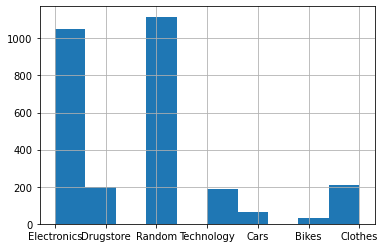

In [56]:
df_domain_attributes_count['domain'].hist()

<AxesSubplot:>

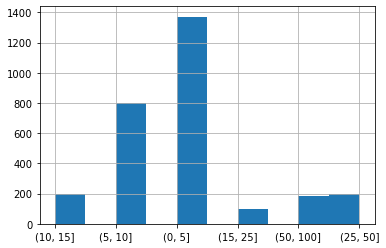

In [57]:
df_domain_attributes_count['binned'].astype(str).hist()

# Create overview

In [58]:
#load test data
df_test= pd.read_json(os.path.join(train_test_all_filtered_path,'test/concatenated_data/test_all_filtered_tables.json.gz'), compression='gzip', lines=True)
df_test = df_test[['name','description','cluster_id']]
#scale cluster_ids
df_test['label'] = df_test.groupby('cluster_id').ngroup()
df_test['source'] = 'test'

In [59]:
#load test data
df_train= pd.read_json(os.path.join(train_test_all_filtered_path,'train/concatenated_data/train_all_filtered_tables.json.gz'), compression='gzip', lines=True)
df_train = df_train[['name','description','cluster_id']]
#scale cluster_ids
df_train['label'] = df_train.groupby('cluster_id').ngroup()
df_train['source']='train'

In [60]:
df_train_f1 = pd.merge(df_train, df_f1, how="left", on=["label", "label"])
df_test_f1 = pd.merge(df_test, df_f1, how="left", on=["label", "label"])

In [61]:
f1_scores = f1_score(real.label, res.prediction, average=None, labels=real.label)
f1_scores_with_labels = {label:score for label,score in zip(real.label, f1_scores)}
df_f1 = pd.DataFrame.from_dict(f1_scores_with_labels, orient="index").reset_index().rename(columns={'index':'label',0:'f1'}).sort_values(by=['label'])

In [62]:
pd.concat([df_train_f1, df_test_f1], ignore_index=True, sort=False)

,name,description,cluster_id,label,source,f1
0,rum body lotion.,a lightweight rum-scented body lotion that abs...,1257145,736,train,0.727273
1,Cisco Catalyst WS-C2960X-24TD-L Stackable Rack...,nan,758825,542,train,0.833333
2,Laurel Heights Charcoal Crest LH99,Marchand's Interior & Hardware in Gonzales has...,18329550,1201,train,1.000000
3,Laurel Heights Gray Summit LH98,Marchand's Interior & Hardware in Gonzales has...,52605388,1312,train,0.800000
4,Laurel Heights Gray Summit LH98,Marchand's Interior & Hardware in Gonzales has...,41513137,1277,train,0.857143
...,...,...,...,...,...,...
21771,Apple Lightning to USB-C Cable (2m),Apple Lightning to USB-C Cable (2m),51314,70,test,0.800000
21772,Apple Lightning to VGA adapter,Apple Lightning to VGA adapter,185147,184,test,0.666667
21773,Apple Lightning to Digital AV adapter,Apple Lightning to Digital AV adapter,32374,45,test,0.666667
21774,Rolex Watches Oyster Perpetual GMT-Master II 1...,Brand : Replica Rolex Collection : Oyster Perp...,800686,565,test,1.000000
